1. ทดลองซ้ำและการปรับพารามิเตอร์ให้มากกว่าใน lecture หรือลอง generate date ที่แตกต่างจากที่เรียน

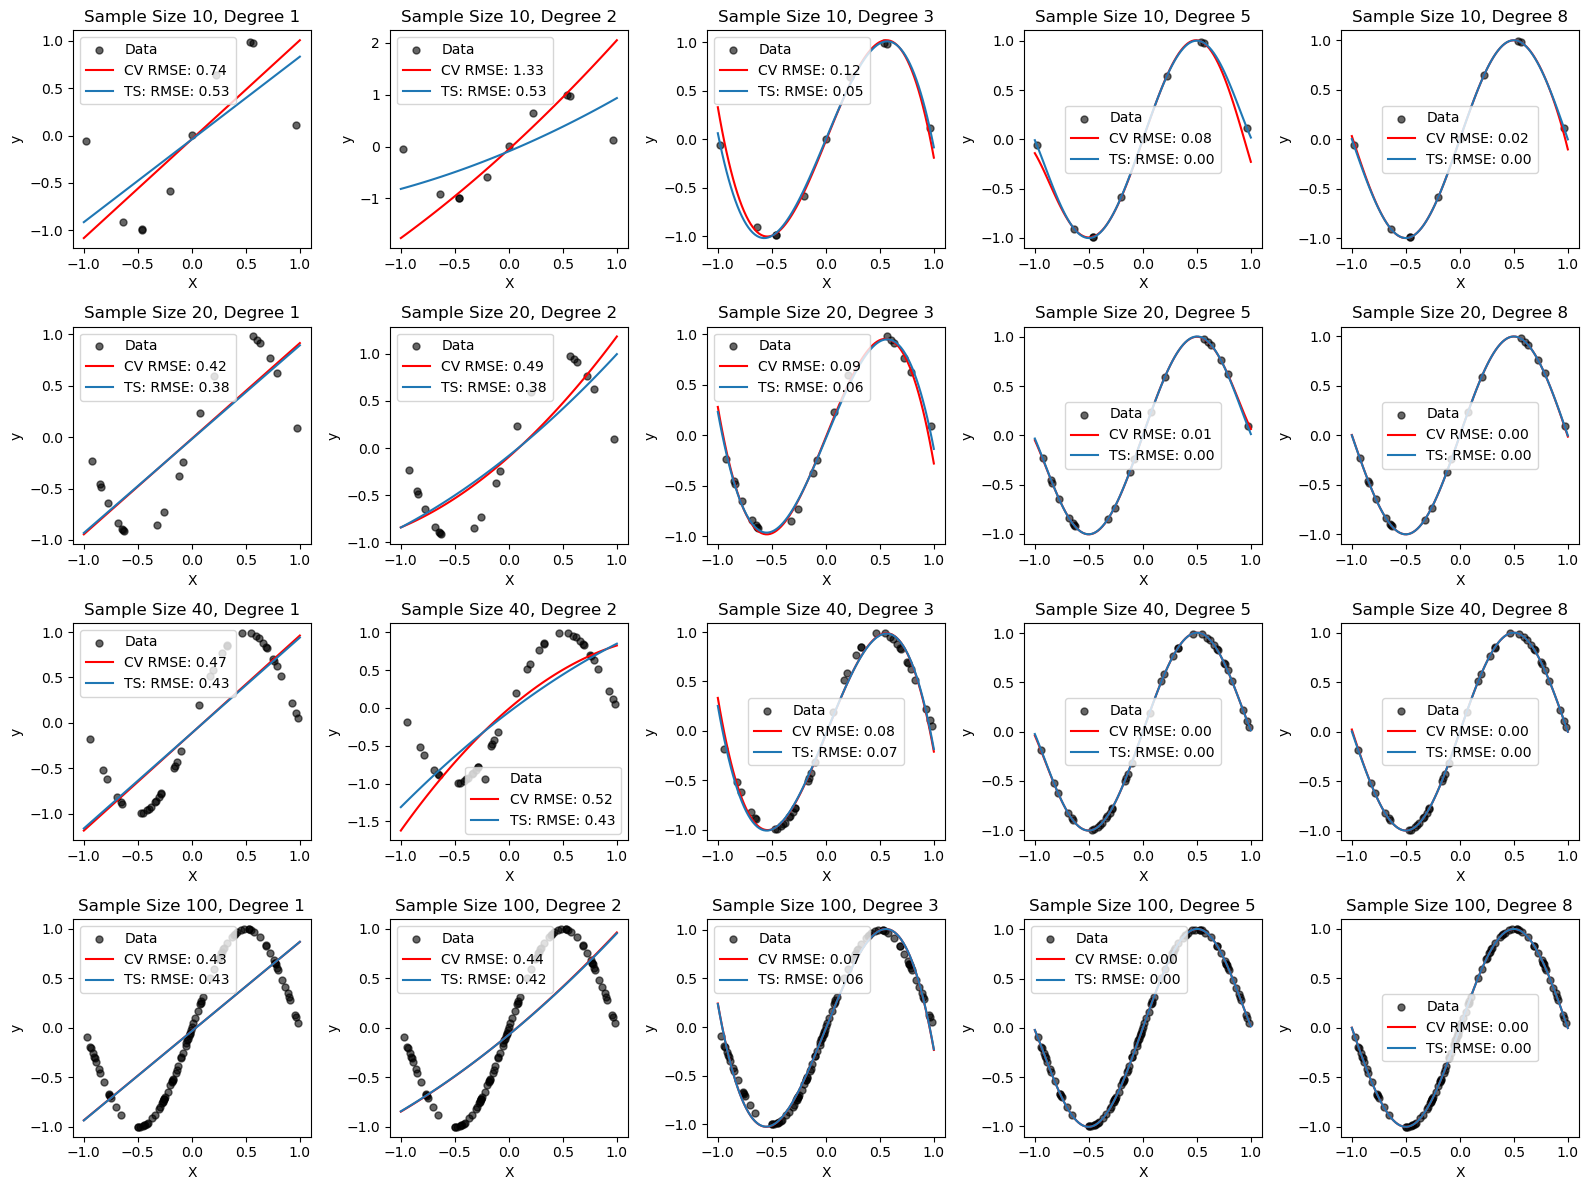

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error

sample_sizes = [10, 20, 40, 100]

plt.figure(figsize=(16, 12))

for i, sample_size in enumerate(sample_sizes):
    
    X = np.random.uniform(-1, 1, size=(sample_size, 1))
    y = np.sin(np.pi * X).ravel()

    degrees = [1, 2, 3, 5, 8]

    for j, degree in enumerate(degrees):
        poly = PolynomialFeatures(degree)
        X_poly = poly.fit_transform(X)
        X_train_poly = poly.fit_transform(X)
        X_test_poly = poly.transform(X)

        model1 = LinearRegression()
        model2 = LinearRegression()

        y_pred = cross_val_predict(model1, X_poly, y, cv=10)
        rmse1 = np.sqrt(mean_squared_error(y, y_pred))

        model2.fit(X_train_poly, y)
        y_train_pred = model2.predict(X_train_poly)
        y_test_pred = model2.predict(X_test_poly)

        rmse2 = np.sqrt(np.mean((y - y_test_pred)**2))

        X_range = np.linspace(-1, 1, 100).reshape(-1, 1)
        X_range_poly = poly.transform(X_range)
        y_range_pred1 = model1.fit(X_poly, y_pred).predict(X_range_poly)
        
        y_range_pred2 = model2.predict(X_range_poly)

        plt.subplot(len(sample_sizes), len(degrees), i * len(degrees) + j + 1)
        plt.scatter(X, y, s=25, alpha=0.6,color = 'black', label='Data')  # Highlight train data
        plt.plot(X_range, y_range_pred1, color = 'red',label=f'CV RMSE: {rmse1:.2f}')
        plt.plot(X_range, y_range_pred2, label=f'TS: RMSE: {rmse2:.2f}')
        plt.xlabel('X')
        plt.ylabel('y')
        plt.title(f"Sample Size {sample_size}, Degree {degree}")
        plt.legend()

plt.tight_layout()
plt.show()


Bias vs Variance

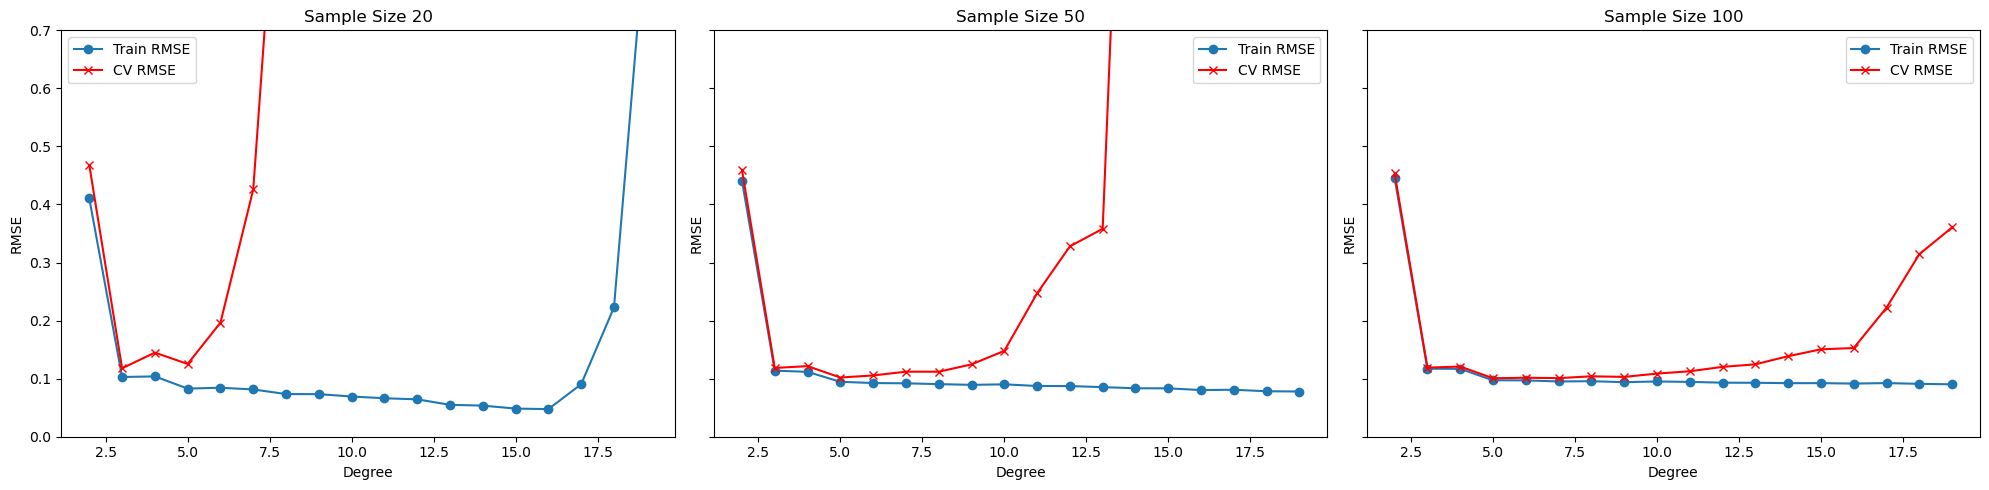

In [2]:
import numpy as np
import matplotlib.pyplot as plt

sample_sizes = [20,50,100]
degrees = range(2,20)
cv_folds = 10
num_seeds = 100

def polynomial_func(X, degree):
    polynomial_equation = [X ** i for i in range(1, degree + 1)]
    return np.hstack(polynomial_equation)

def normal_equation(X, Y):
    A = np.dot(X.T, X)
    B = np.dot(X.T, Y)
    A_I = np.linalg.inv(A)
    W = np.dot(A_I, B)
    return W

def MSE_upgrade(X_train, X_test, y_train, y_test):
    W = normal_equation(X_train, y_train)
    y_pred = np.dot(X_test, W)
    S = (y_pred - y_test) ** 2
    return np.mean(S)

def training_CV_polynomial(degrees, sample_sizes, fold, num_seeds):
    avg_train_errors = np.zeros((len(degrees), len(sample_sizes)))
    avg_cv_errors = np.zeros((len(degrees), len(sample_sizes)))

    for seed in range(num_seeds):
        np.random.seed(seed)

        for idx, deg in enumerate(degrees):
            train_errors = []
            cv_errors = []

            for sample_size in sample_sizes:
                X = np.random.uniform(-1, 1, size=(sample_size, 1))
                y = np.sin(np.pi * X).ravel() + np.random.normal(0, 0.1, X.shape[0])

                split_size = sample_size // fold

                fold_cv_mse = []

                X_poly = polynomial_func(X, deg)

                for i in range(fold):
                    X_test = X[i * split_size:(i + 1) * split_size]
                    Y_test = y[i * split_size:(i + 1) * split_size]

                    X_train = np.concatenate((X[:i * split_size], X[(i + 1) * split_size:]), axis=0)
                    Y_train = np.concatenate((y[:i * split_size], y[(i + 1) * split_size:]), axis=0)

                    X_poly_train = polynomial_func(X_train, deg)
                    X_poly_test = polynomial_func(X_test, deg)

                    cv_error = np.sqrt(MSE_upgrade(X_poly_train, X_poly_test, Y_train, Y_test))
                    fold_cv_mse.append(cv_error)

                train_error = np.sqrt(MSE_upgrade(X_poly, X_poly, y, y))
                cv_avg_mse = np.mean(fold_cv_mse)

                train_errors.append(train_error)
                cv_errors.append(cv_avg_mse)

            avg_train_errors[idx, :] += train_errors
            avg_cv_errors[idx, :] += cv_errors

    avg_train_errors /= num_seeds
    avg_cv_errors /= num_seeds

    fig, axs = plt.subplots(1, len(sample_sizes), figsize=(20, 5), sharey=True)
    for idx, sample_size in enumerate(sample_sizes):
        axs[idx].plot(degrees, avg_train_errors[:, idx], marker='o', label=f'Train RMSE')
        axs[idx].plot(degrees, avg_cv_errors[:, idx], color='red', marker='x', label=f'CV RMSE')
        axs[idx].set_title(f'Sample Size {sample_size}')
        axs[idx].set_xlabel('Degree')
        axs[idx].set_ylabel('RMSE')
        axs[idx].legend()
        axs[idx].set_ylim([0, 0.7])


    plt.tight_layout()
    plt.show()

training_CV_polynomial(degrees, sample_sizes, cv_folds, num_seeds)


2. เขียนโปรแกรมสำหรับการทำ Nested Cross-Validation และออกแบบการทดลองเพื่อแสดงให้เห็นถึงความจำเป็นของการทำสองลูปแทนที่จะทำเพียงแค่ลูปเดียว

Noisy

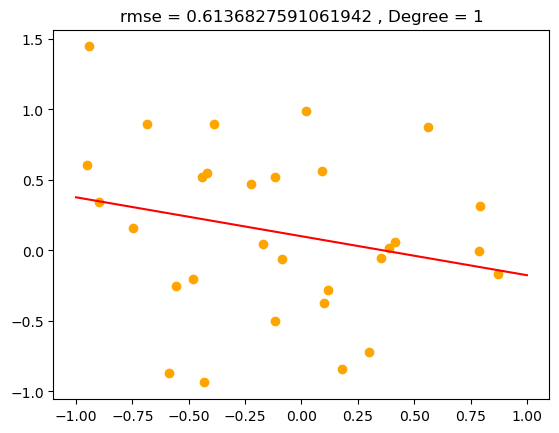

In [3]:
import numpy as np
from pandas import *
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

def Normal_Equation(X,Y):
    A = np.dot(X.T ,X)
    B = np.dot(X.T , Y)
    A_I = np.linalg.inv(A)
    W = np.dot(A_I,B)
    return W

def MSE(X_train, X_test, y_train, y_test):
    X_train = np.c_[np.ones((X_train.shape[0], 1)), X_train]
    theta = Normal_Equation(X_train,y_train)
    print(theta)
    print(X_test)
    w0 = theta[0]
    w1 = theta[1]
    S = 0
    S = np.sum(((w0 + w1*X_test)-y_test)**2)
    return S/(len(X_test))

def MSE_upgrade(X_train, X_test, y_train, y_test):
    W = Normal_Equation(X_train,y_train)
    S = 0
    for j in range(len(W)):
        S += ((W[j] * X_test ** j))
    S = (S - y_test) ** 2
    return (np.mean(S))

def cross_validation(X,Y,k):
    m = 0
    n = len(X)//k
    meanS = []
    theta_list = []
    for i in range(k):
        X_s = X
        Y_s = Y
        X_test = X_s[m:n]
        Y_test = Y_s[m:n]
        X_train = np.delete(X_s,np.s_[m:n],axis=0)
        Y_train = np.delete(Y_s,np.s_[m:n],axis=0)
        meanS.append(math.sqrt(MSE(X_train, X_test, Y_train, Y_test)))
        m += len(X) // k
        n += len(X) // k

    return np.mean(meanS)

def plotModel_trainning (Degree):
    meanMSE = []
    plt.figure(figsize=(8,18))
    plt.ylim([-1,1])
    np.random.seed(100)
    x = np.linspace(-1, 1, 100)
    X_shuffled = np.random.uniform(-1, 1, size=(100, 1))
    Y_shuffled = np.sin(np.pi * X_shuffled) 
    X_with_intercept = np.ones((X_shuffled.shape[0], 1))
    for i in range(1,Degree+1):
        X_with_intercept = np.c_[X_with_intercept , X_shuffled ** i]
        meanMSE.append(math.sqrt(MSE_upgrade(X_with_intercept, X_shuffled, Y_shuffled, Y_shuffled)))
    theta = Normal_Equation(X_with_intercept, Y_shuffled)
    y = theta[0]
    for j in range(1,len(theta)):
        y = y + theta[j] * x ** j
        plt.subplot(Degree , 1 , j)
        plt.plot(x, y,color='red')
        plt.scatter(X_shuffled, Y_shuffled, color='orange', label='Random Points')
        plt.title(f"rmse = {meanMSE[j-1]}")

def plotModel_CV (Degree, k = 5):
    samplesize = 30


    np.random.seed(3)
    x = np.linspace(-1, 1, 100)
    X_shuffled = np.random.uniform(-1, 1, size=(samplesize, 1))
    Y_shuffled = (X_shuffled ** 2) + np.random.normal(0, 0.5, size=(samplesize, 1))
    m = 0
    n = len(X_shuffled)//k
    meanS = []
    meanMSE = []
    theta_list = []
    for i in range(k):
        list_mse = []
        X_s = X_shuffled
        Y_s = Y_shuffled
        X_test = X_s[m:n]
        Y_test = Y_s[m:n]
        X_train = np.delete(X_s,np.s_[m:n],axis=0)
        Y_train = np.delete(Y_s,np.s_[m:n],axis=0)
        X_with_intercept = np.ones((X_train.shape[0], 1))
        for i in range(1,Degree+1):
            X_with_intercept = np.c_[X_with_intercept , X_train ** i]
            list_mse.append(math.sqrt(MSE_upgrade(X_with_intercept, X_test, Y_train, Y_test))) # mse ของทุก degree
        meanS.append(list_mse) # mse ของทุก degree แต่ละ fold
        theta = Normal_Equation(X_with_intercept, Y_train)
        theta_list.append(theta)
        m += len(X_shuffled) // k
        n += len(X_shuffled) // k

    mean_theta = []
    for j in range(Degree):
        s = 0
        for i in range(len(meanS)):
            s += meanS[i][j]
        meanMSE.append(s/len(meanS))

    for j in range(Degree+1):
        s = 0
        for i in range(k):
            s += theta_list[i][j]
        mean_theta.append(s/len(theta_list))
    
    y = mean_theta[0][0]
    for j in range(1,len(mean_theta)):
        y = y + mean_theta[j][0] * x ** j

    plt.plot(x, y,color='red')
    plt.scatter(X_shuffled, Y_shuffled, color='orange', label='Random Points')
    plt.title(f"rmse = {meanMSE[j-1]} , Degree = {j}")

plotModel_CV (1)

Noiseless

(5.804080835674028e-10, 13)


c:\Users\Best\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Best\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


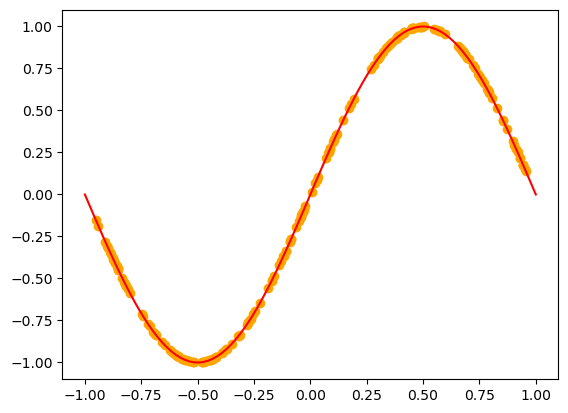

In [4]:
import numpy as np
from pandas import *
import math
import matplotlib.pyplot as plt
import pandas as pd

def Normal_Equation(X,Y):
    A = np.dot(X.T ,X)
    B = np.dot(X.T , Y)
    A_I = np.linalg.inv(A)
    W = np.dot(A_I,B)
    return W

def MSE(X_train, X_test, y_train, y_test):
    X_train = np.c_[np.ones((X_train.shape[0], 1)), X_train]
    theta = Normal_Equation(X_train,y_train)
    w0 = theta[0]
    w1 = theta[1]
    S = 0
    S = np.sum(((w0 + w1*X_test)-y_test)**2)
    return S/(len(X_test))

def MSE_upgrade(X_train, X_test, y_train, y_test):
    W = Normal_Equation(X_train,y_train)
    S = 0
    for j in range(len(W)):
        S += ((W[j] * X_test ** j))
    S = (S - y_test)**2
    return (np.mean(S))

def cross_validation(X,Y,k,Degree):
    m = 0
    n = len(X)//k
    meanS = []
    theta_list = []
    for i in range(k):
        X_s = X
        Y_s = Y
        X_test = X_s[m:n]
        Y_test = Y_s[m:n]
        X_train = np.delete(X_s,np.s_[m:n],axis=0)
        Y_train = np.delete(Y_s,np.s_[m:n],axis=0)
        X_with_intercept = np.ones((X_train.shape[0], 1))
        for i in range(1,Degree+1):
            X_with_intercept = np.c_[X_with_intercept , X_train ** i]
        theta = Normal_Equation(X_with_intercept, Y_train)
        theta_list.append(theta)

        m += len(X) // k
        n += len(X) // k
    x = np.linspace(-1, 1, 100)
    mean_theta = []
    for i in range(k):
        mean_theta.append(np.average(theta_list[i]))
    y = theta[0]

    for j in range(1,len(theta)):
        y = y + theta[j] * x ** j

    plt.plot(x, y,color='red')
    plt.scatter(X, Y, color='orange', label='Random Points')
    return np.mean(meanS)

def most_common(lst):
    return max(set(lst), key=lst.count)

def CV_upgrade (samplesize, mode, Degree, k = 5):
    np.random.seed(3)
    X_shuffled = np.random.uniform(-1, 1, size=(samplesize, 1))
    if mode == 'noisy':
        Y_shuffled = np.sin(np.pi * X_shuffled) + np.random.normal(0, 0.5, size=(samplesize, 1))
    else :
        Y_shuffled = np.sin(np.pi * X_shuffled)

    m = 0
    n = len(X_shuffled)//k
    meanS = []
    meanMSE = []
    theta_list = []
    for i in range(k):
        list_mse = []
        X_s = X_shuffled
        Y_s = Y_shuffled
        X_test = X_s[m:n]
        Y_test = Y_s[m:n]
        X_train = np.delete(X_s,np.s_[m:n],axis=0)
        Y_train = np.delete(Y_s,np.s_[m:n],axis=0)
        X_with_intercept = np.ones((X_train.shape[0], 1))
        for i in range(1,Degree+1):
            X_with_intercept = np.c_[X_with_intercept , X_train ** i]
            list_mse.append(math.sqrt(MSE_upgrade(X_with_intercept, X_test, Y_train, Y_test))) # mse ของทุก degree
        meanS.append(list_mse) # mse ของทุก degree แต่ละ fold
        theta = Normal_Equation(X_with_intercept, Y_train)
        theta_list.append(theta)
        m += len(X_shuffled) // k
        n += len(X_shuffled) // k

    mean_theta = []
    for j in range(Degree):
        s = 0
        for i in range(len(meanS)):
            s += meanS[i][j]
        meanMSE.append(s/len(meanS))

    return meanMSE[-1]


def Nested_CV (samplesize,mode, k = 5):
    np.random.seed(3)
    X_shuffled = np.random.uniform(-1, 1, size=(samplesize, 1))
    if mode == 'noisy':
        Y_shuffled = np.sin(np.pi * X_shuffled) + np.random.normal(0, 0.5, size=(samplesize, 1))
    else :
        Y_shuffled = np.sin(np.pi * X_shuffled)
    m = 0
    n = len(X_shuffled)//k
    meanS = []
    meanMSE = []
    theta_list = []
    model_Degree = []
    for i in range(k):
        list_mse = []
        X_s = X_shuffled
        Y_s = Y_shuffled
        X_test = X_s[m:n]
        Y_test = Y_s[m:n]
        X_train_val = np.delete(X_s,np.s_[m:n],axis=0)
        Y_train_val = np.delete(Y_s,np.s_[m:n],axis=0)
        f = 0
        l = len(X_train_val)//k
        Degree_list = []
        min_mse = []
        #แบ่งหา degree
        for j in range(k):
            list_mse_val = []
            X_val = X_train_val[f:l]
            X_train = np.delete(X_train_val,np.s_[f:l],axis=0)
            Y_val = Y_train_val[f:l]
            Y_train = np.delete(Y_train_val,np.s_[f:l],axis=0)
            X_with_intercept = np.ones((X_train.shape[0], 1))
            for i in range(1,50):
                X_with_intercept = np.c_[X_with_intercept , X_train ** i]
                list_mse_val.append(math.sqrt(MSE_upgrade(X_with_intercept, X_val, Y_train, Y_val)))
            Degree_list.append((list_mse_val.index(min(list_mse_val)))+1)
            min_mse.append(min(list_mse_val))
            f += len(X_train_val) // k
            l += len(X_train_val) // k
        meanMSE.append(min(min_mse))
        Degree = most_common(Degree_list)
        model_Degree.append(Degree)
        X_with_intercept = np.ones((X_train_val.shape[0], 1))
        for i in range(1,Degree+1):
            X_with_intercept = np.c_[X_with_intercept , X_train_val ** i]
        meanS.append(math.sqrt(MSE_upgrade(X_with_intercept, X_test, Y_train_val, Y_test)))
        m += len(X_shuffled) // k
        n += len(X_shuffled) // k
    
    cross_validation(X_shuffled,Y_shuffled,k,most_common(model_Degree))
    return np.mean(meanMSE), most_common(model_Degree)

print(Nested_CV(200,'noiseless'))